In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datasets
import torch
from torch.utils.data import DataLoader
from train import get_model_class
%load_ext autoreload
%autoreload 2

In [2]:
random_sources = ['rs', 'loo']

In [3]:
name = 'heloc'  # or 'german'
n_models = 100  # 1000 for german if needed
trainset, testset = datasets.load_dataset(name)

X_test, y_test = testset.data.numpy(), testset.labels.numpy()
n_inputs, input_size = X_test.shape
model_args = [input_size, datasets.tabular.layers[name]]
directory = f'models/{name}'
directory

'models/heloc'

### Compute and save predictions from models

In [4]:
model_class = get_model_class(name)
for random_source in random_sources:
    for i in range(n_models):
        model = model_class(*model_args)
        state_dict = torch.load(f'{directory}/{random_source}_model_{i}.pth')
        model.load_state_dict(state_dict)
        pred = model.predict(X_test)
        np.save(f'{directory}/{random_source}_preds_{i}.npy', pred)

### Compute and save gradients from models

In [5]:
model_class = get_model_class(name)
for random_source in random_sources:
    for i in range(n_models):
        model = model_class(*model_args)
        state_dict = torch.load(f'{directory}/{random_source}_model_{i}.pth')
        model.load_state_dict(state_dict)
        # Compute positive class softmax prediction gradient wrt input (softmax=False for logit output)
        grads = model.compute_gradients(X_test, softmax=False, return_numpy=True)
        np.save(f'{directory}/{random_source}_grads_{i}.npy', grads)

### How to load/visualize gradients

In [11]:
# Set ensemble size
size_ensemble = 10

In [12]:
# Randomly sample size_ensemble indices from 0 to n_models
indices = np.random.choice(n_models, size_ensemble, replace=False)
indices

array([51, 32, 24,  1, 17, 43, 89, 11, 96, 95])

In [13]:
# Load predictions and gradients for models with those indices
preds = np.array([np.load(f'{directory}/{random_source}_preds_{i}.npy') for i in indices])
grads = np.array([np.load(f'{directory}/{random_source}_grads_{i}.npy') for i in indices])

In [14]:
# grads has size (size_ensemble, n_inputs, n_features) for tabular data
n_inputs, n_features = grads.shape[1:]
n_inputs, n_features

(1975, 23)

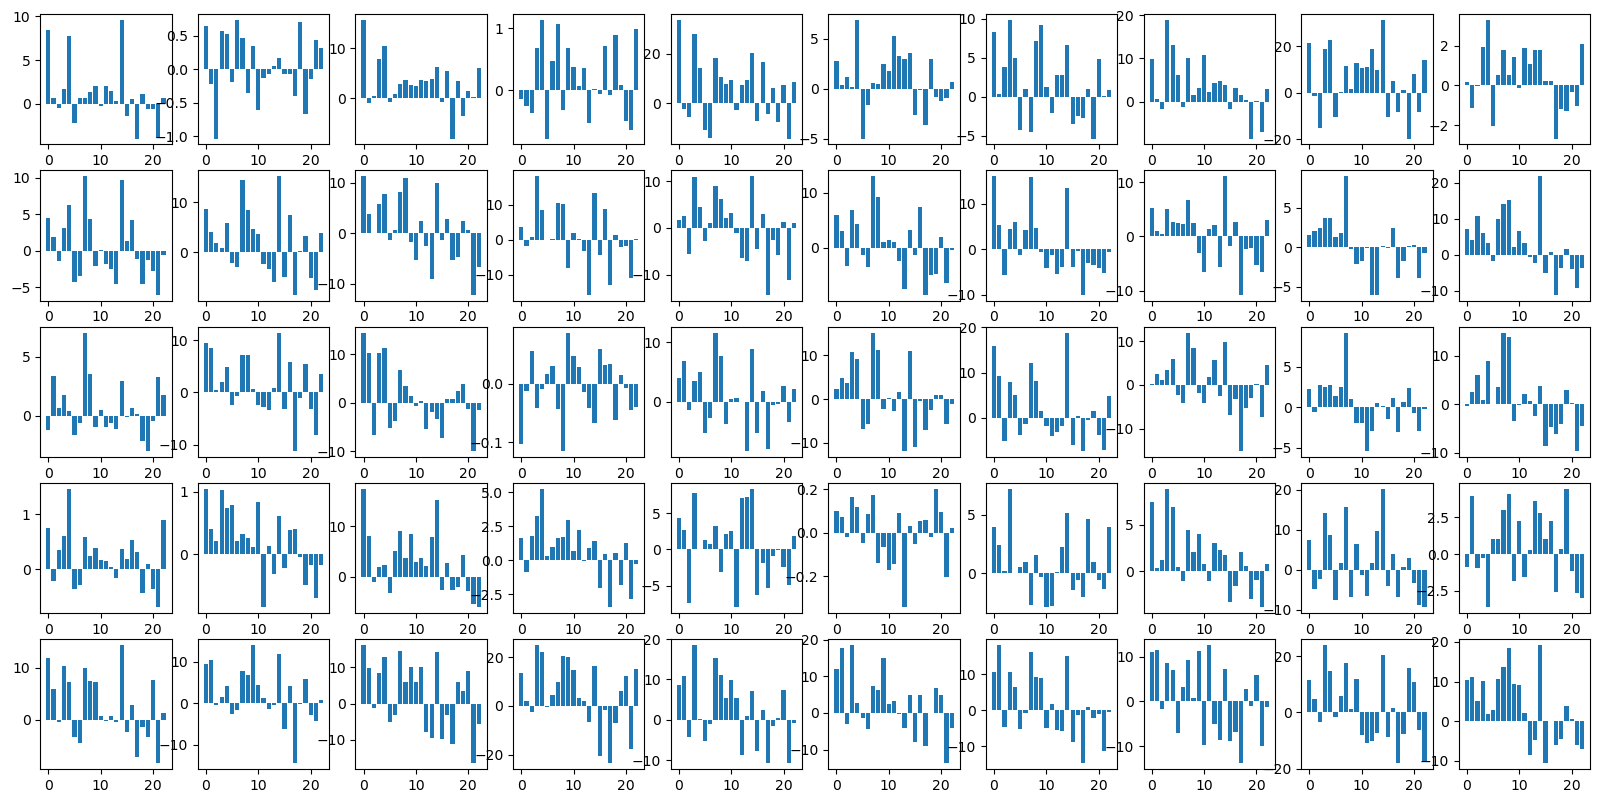

In [15]:
# Visualize gradients for each of the models in the ensemble for first 5 inputs
# Rows are inputs, columns are models
rows = 5
fig, axs = plt.subplots(rows, size_ensemble, figsize=(rows*4, size_ensemble), dpi=100)
for i in range(5):
    for j in range(size_ensemble):
        axs[i,j].bar(range(n_features), grads[j,i])
plt.show()

Okay so some gradients are zero... moreso if you do softmax gradient instead of logit gradient

Might just be a floating point error (could try float64 instead of float32 but will double the storage size)

softmax gradient and logit gradient should be the same (?), just softmax is magnitudes smaller

### Top k and comparisons

In [16]:
print("(no. models in ensemble, no. test inputs, no. features)")
print(grads.shape)

(no. models in ensemble, no. test inputs, no. features)
(10, 1975, 23)


In [17]:
from similarity_metrics import get_top_k

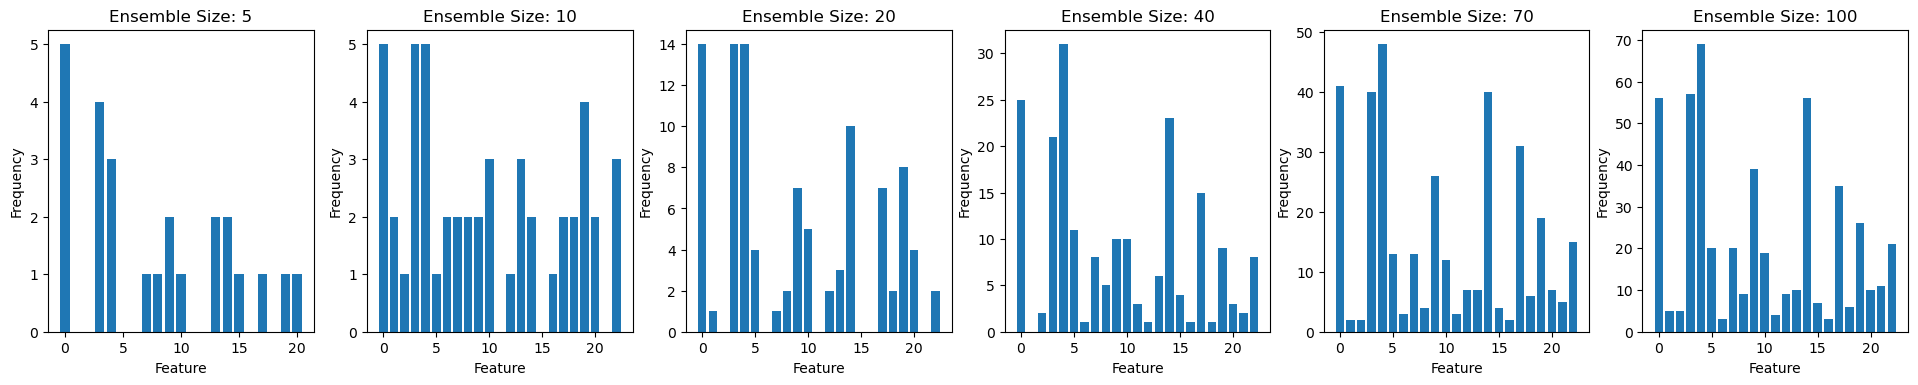

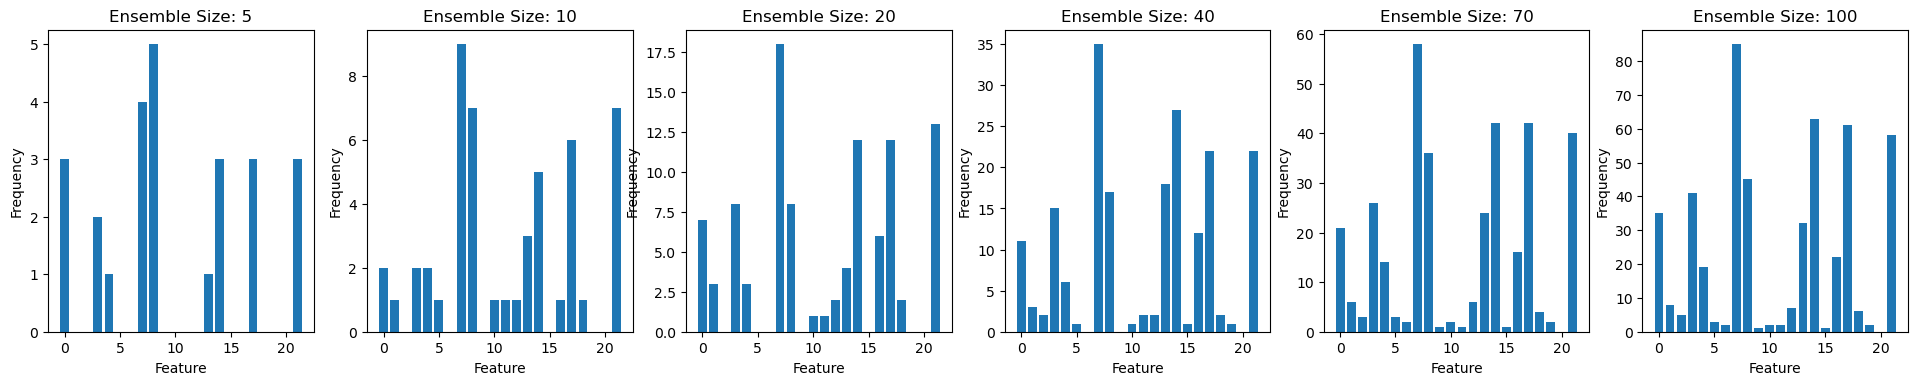

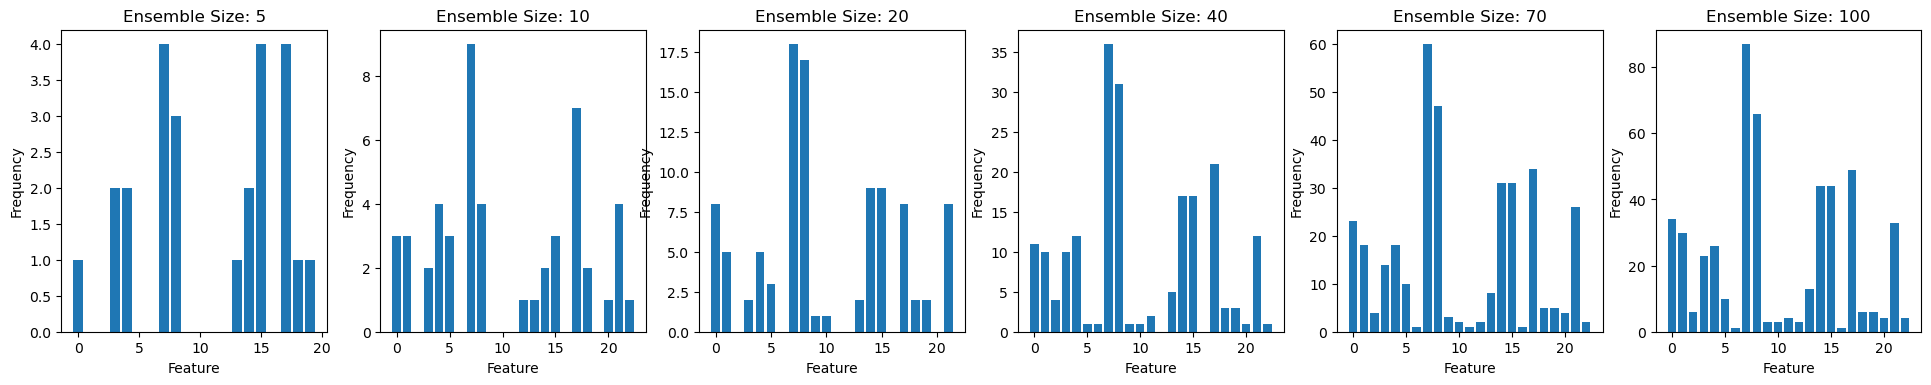

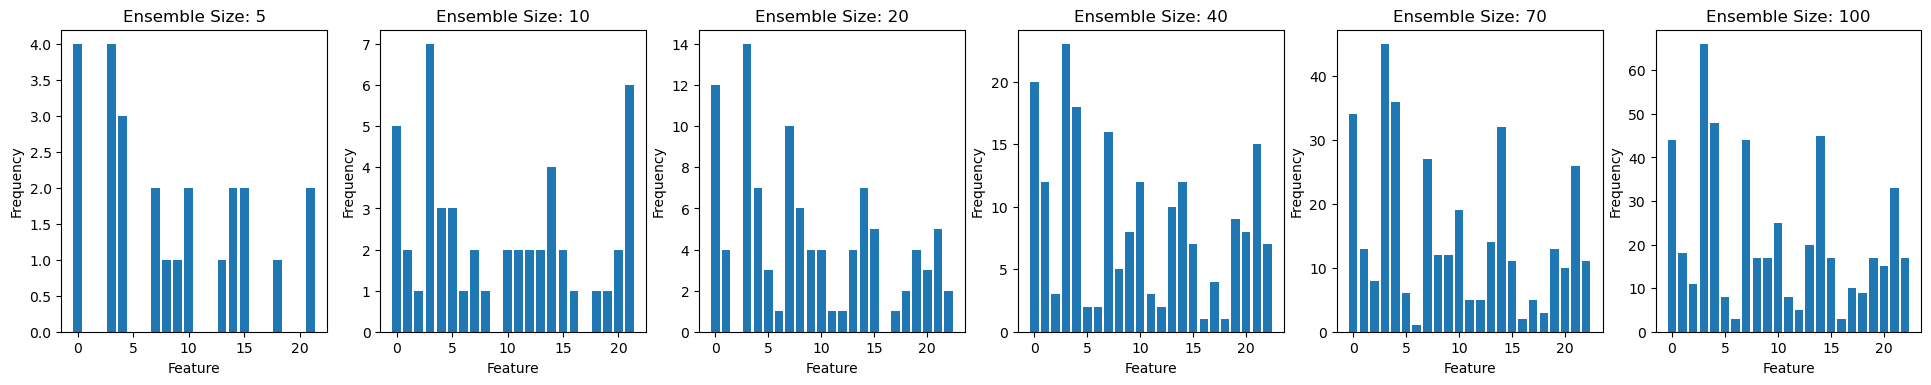

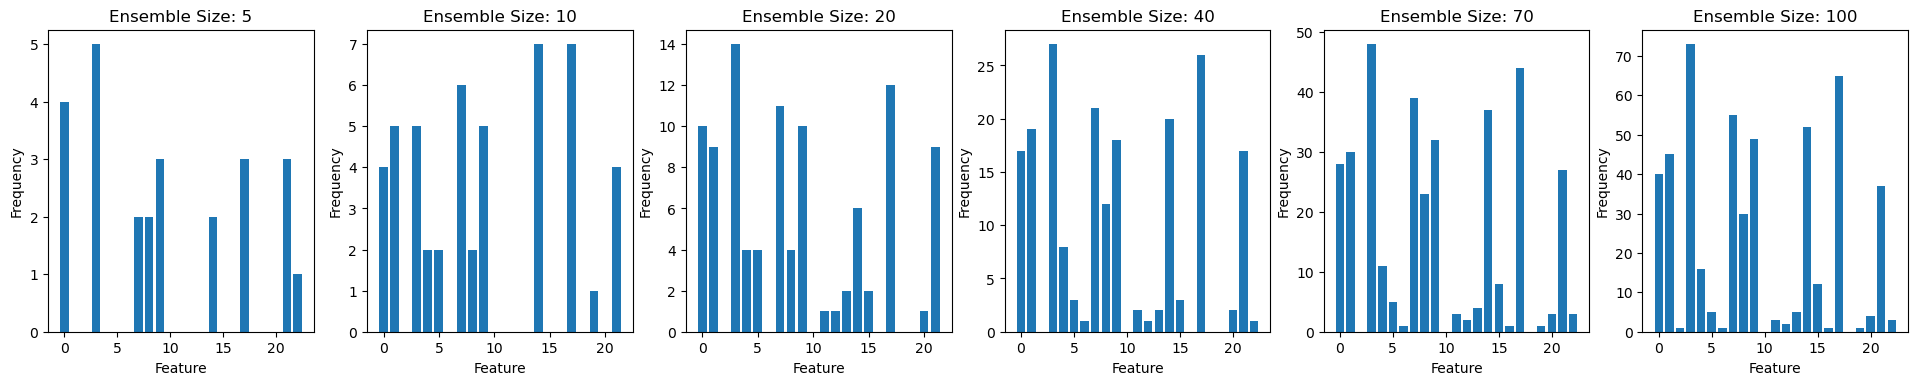

In [42]:
ensemble_sizes = [5, 10, 20, 40, 70, 100]
# Randomly sample size_ensemble indices from 0 to n_models for each ensemble size, load grads, and get top k grads
top5 = []
n_test = 5
counts = np.zeros((n_test, len(ensemble_sizes), n_features))
for i in range(n_test):
    fig, axs = plt.subplots(1, len(ensemble_sizes), figsize=(len(ensemble_sizes)*4, 4), dpi=100)
    for j, size_ensemble in enumerate(ensemble_sizes):
        indices = np.random.choice(n_models, size_ensemble, replace=False)  # should do this many times
        grads = np.array([np.load(f'{directory}/{random_source}_grads_{idx}.npy') for idx in indices])
        top5.append(np.array([get_top_k(grads[idx], k=5) for idx in range(size_ensemble)]))
        un, co = np.unique(top5[j][:, i].flatten(), return_counts=True)
        axs[j].bar(un, co)
        axs[j].set_xlabel('Feature')
        axs[j].set_ylabel('Frequency')
        axs[j].set_title(f'Ensemble Size: {size_ensemble}')
        counts[i, j, un] = co
    plt.show()

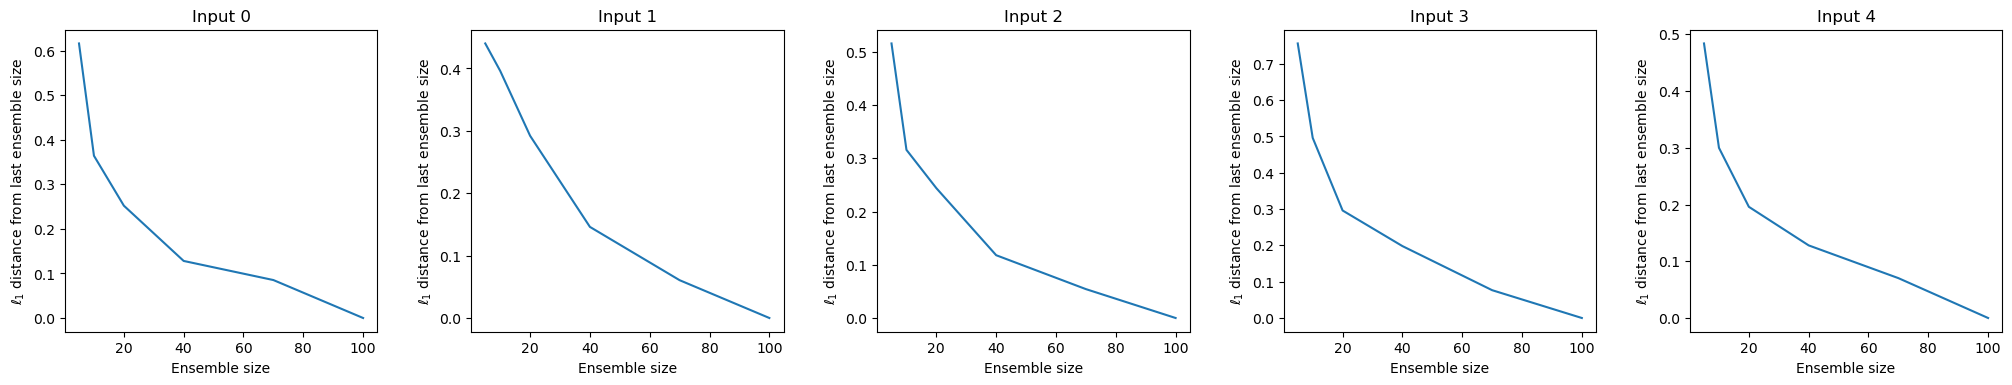

In [41]:
fig, axs = plt.subplots(1, n_test, figsize=(n_test*5, 4), dpi=100)
plt.subplots_adjust(wspace=0.3)
for i in range(n_test):
    counts_norm = counts[i]/np.sum(counts[i], axis=1)[:, None]
    axs[i].plot(ensemble_sizes, np.linalg.norm(counts_norm-counts_norm[-1], axis=1, ord=1))
    axs[i].set_xlabel('Ensemble size')
    axs[i].set_ylabel('$\ell_1$ distance from last ensemble size')
    axs[i].set_title(f'Input {i}')
plt.show()

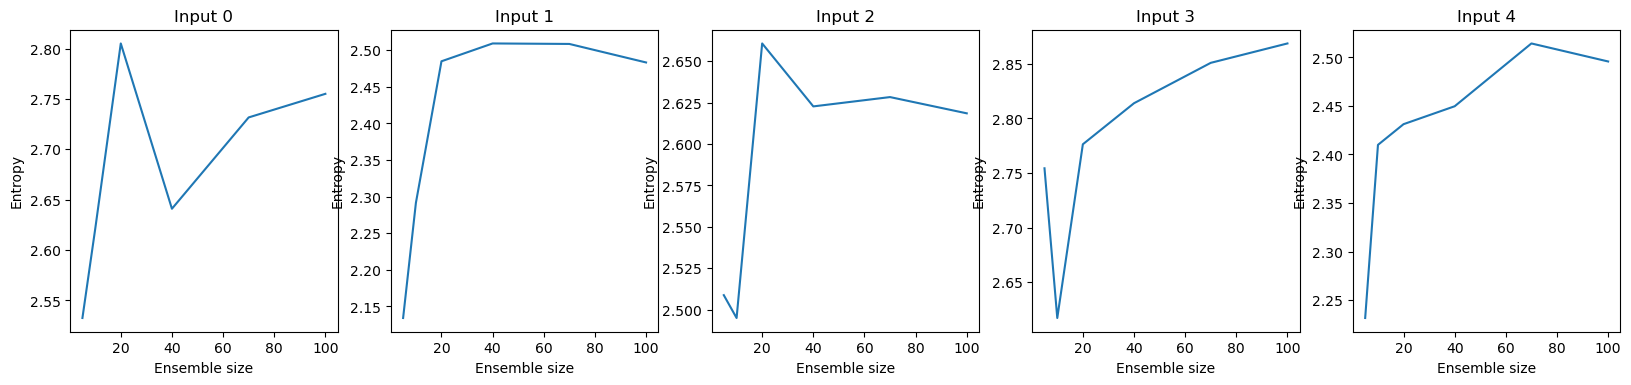

In [20]:
# Compute entropy of each feature distribution in counts
from scipy.stats import entropy
# Plot entropy of counts for each input
fig, axs = plt.subplots(1, n_test, figsize=(n_test*4, 4), dpi=100)
for i in range(n_test):
    full_counts_norm = counts[i, -1]/np.sum(counts[i, -1])
    counts[0]/np.sum(counts[0], axis=1)[:, None]
    axs[i].plot(ensemble_sizes, entropy(counts[i], axis=1))
    axs[i].set_xlabel('Ensemble size')
    axs[i].set_ylabel('Entropy')
    axs[i].set_title(f'Input {i}')
plt.show()

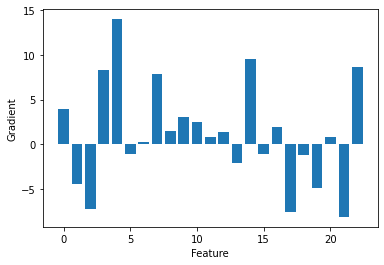

In [65]:
# Function for a single gradient plot
def plot_grad(grad, k=-1):
    # Optional top k gradients by absolute value
    if k > 0:
        grad = grad[np.argsort(np.abs(grad))[-k:]]
    plt.bar(range(grad.shape[0]), grad)
    plt.ylabel('Gradient')
    plt.xlabel('Feature')
    plt.show()

plot_grad(grads[0,0])